## <font color='darkblue'>Introduction</font>
([article source](https://towardsdatascience.com/transforming-skewed-data-73da4c2d0d16)) <b>Skewed data is cumbersome and common. It’s often desirable to transform skewed data and to convert it into values between 0 and 1.</b> Standard functions used for such conversions include Normalization, the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function), Log, Cube Root and the Hyperbolic Tangent. It all depends on what one is trying to accomplish.

Here’s an example of a skewed column that I generated from an 8.9 million row [Amazon Books Review Dataset](http://jmcauley.ucsd.edu/data/amazon/) (Julian McAuley, UCSD). df.Helpful_Votes gives the total number of helpful votes (as opposed to unhelpful) that each book review received.

In [1]:
# Loading data
import numpy as np
import pandas as pd
import gzip

'''
count    4.756338e+06
mean     5.625667e+00
std      2.663631e+01
min      0.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      2.331100e+04
'''
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

# %time df = getDF('reviews_Books_5.json.gz')

In [5]:
# You can download the txt file under link below
# https://drive.google.com/file/d/1LsIgXjPxWNZM57PSp6oXWvVw5ObxHXio/view?usp=sharing
i = 0
tdf = {}
with open("transforming_skewed_data_helpful_sum.txt", 'r') as fh:
    i = 0
    for line in fh:
        line = line.strip()
        if line:
            d = {"data": int(line)}
            tdf[i] = d
            i+=1
            # if i > 0 and i % 500000 == 0:
            #    print("{:,d} done!".format(i))
            
df = pd.DataFrame.from_dict(tdf, orient='index')
df.head()

,data
0,0
1,2
2,0
3,0
4,16


In [6]:
df.data.describe()

count    8.898041e+06
mean     7.058054e+00
std      4.198380e+01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      4.000000e+00
max      4.752300e+04
Name: data, dtype: float64

From the distribution of data, 0 (min), 0(25%), 1(50%), 4(75%), 47523(max). That’s quite a jump! <br/>
Let's check more charts to see how skewed this data is:

In [39]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from collections import Counter

data_size = df.shape[0]
data_cntr = Counter(df.data.tolist())

In [45]:
# Top 10 helper count ->  0:4141204  means there are 4,141,204 books has 0 helpful vote
sorted(data_cntr.items(), key=lambda t: t[0])[:10]

[(0, 4141204),
 (1, 397492),
 (2, 1332984),
 (3, 335779),
 (4, 507694),
 (5, 204627),
 (6, 273489),
 (7, 144149),
 (8, 174965),
 (9, 96911)]

In [140]:
def plot_accum_pert_dist(data_cntr, upper_bound=500):
    max_helper_count, min_helper_count = max(data_cntr.keys()), min(data_cntr.keys())
    x_helper_vote_count = list(range(0, upper_bound+1))
    y_pert_list, accum = [], 0
    line_25 = line_50 = line_75 = -1
    for i in range(0, upper_bound):
        accum += data_cntr[i]
        pert = 100 * accum / data_size
        y_pert_list.append(pert)
        if line_25 < 0 and pert >= 25:
            line_25 = i
        if line_50 < 0 and pert >= 50:
            line_50 = i
        if line_75 < 0 and pert >= 75:
            line_75 = i
    y_pert_list.append(100.0)
    
    # Accumulated percentage distribution
    plt.figure(figsize=(12,6),dpi=100,linewidth = 2)
    plt.plot(x_helper_vote_count, y_pert_list,'s-',color = 'b', label="TSMC")
    plt.xlabel(f"helper vote count (min={min_helper_count};max={max_helper_count:,d})\nGreen line: 25% (x={line_25})\nOrange line: 50% (x={line_50})\nRed line: 75% (x={line_75})", fontsize=10, labelpad = 15)
    plt.ylabel("accumulated percentage", fontsize=10, labelpad = 20)
    plt.axvline(x=line_25, linewidth=1, color='green')
    plt.axvline(x=line_50, linewidth=1, color='orange')
    plt.axvline(x=line_75, linewidth=1, color='r')
    plt.show()

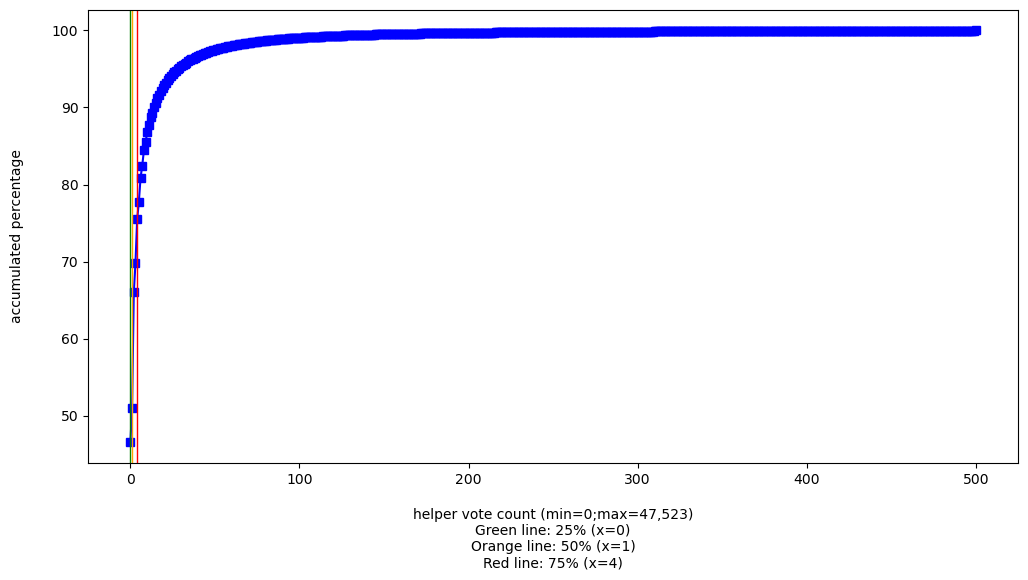

In [141]:
plot_accum_pert_dist(data_cntr)

From above accumulated percentage distribution, we can observe that <b>the data above is skewed!</b>

Removing outliers is an option, but not one that I want to use here. My end goal is to build a machine learning algorithm to predict whether a given review is helpful, so reviews with the most helpful votes are indispensable.

I will use the functions listed above to transform the data, explaining pros and cons along the way. <b>As with most data science, there is no correct function. It depends on the data, and the goal of the analyst.</b>

Normalization converts all data points to decimals between 0 and 1. If the min is 0, simply divide each point by the max; If the min is not 0, subtract the min from each point, and then divide by the min-max difference.

The following function includes by both cases.

## <font color='darkblue'>Normalization Function</font>
First of all, let's try the intuitive approach to do normalization:

In [7]:
def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y

helpful_normalized = normalize(df.data)
helpful_normalized.describe()

count    8.898041e+06
mean     1.485187e-04
std      8.834418e-04
min      0.000000e+00
25%      0.000000e+00
50%      2.104244e-05
75%      8.416977e-05
max      1.000000e+00
Name: data, dtype: float64

In [83]:
normalized_cntr = Counter(map(lambda v: int(v*500), helpful_normalized.tolist()))
sorted(normalized_cntr.items(), key=lambda t: t[0])[:20]

[(0, 8806366),
 (1, 61967),
 (2, 15383),
 (3, 5911),
 (4, 2916),
 (5, 1600),
 (6, 1038),
 (7, 633),
 (8, 464),
 (9, 355),
 (10, 259),
 (11, 214),
 (12, 138),
 (13, 103),
 (14, 75),
 (15, 80),
 (16, 53),
 (17, 64),
 (18, 42),
 (19, 38)]

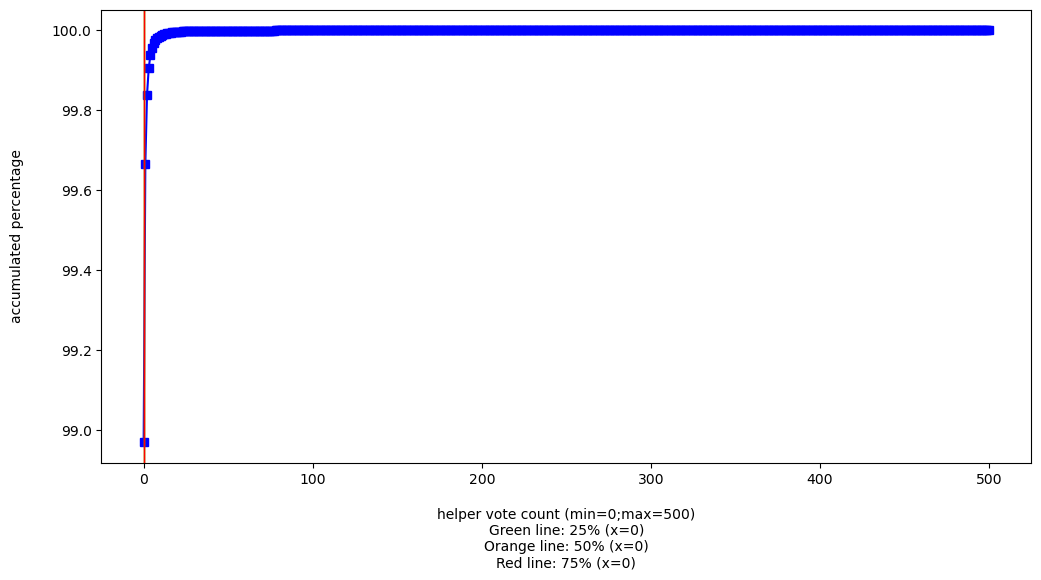

In [142]:
plot_accum_pert_dist(normalized_cntr, upper_bound=500)

After normalization, the data is just as skewed as before. If the goal is simply to convert the data to points between 0 and 1, normalization is the way to go. Otherwise, normalization should be used in conjunction with other functions.

### <font color='darkgreen'>Sigmoid function</font>
Next, the Sigmoid function. It’s worth looking at a visual if you have not seen the Sigmoid before.

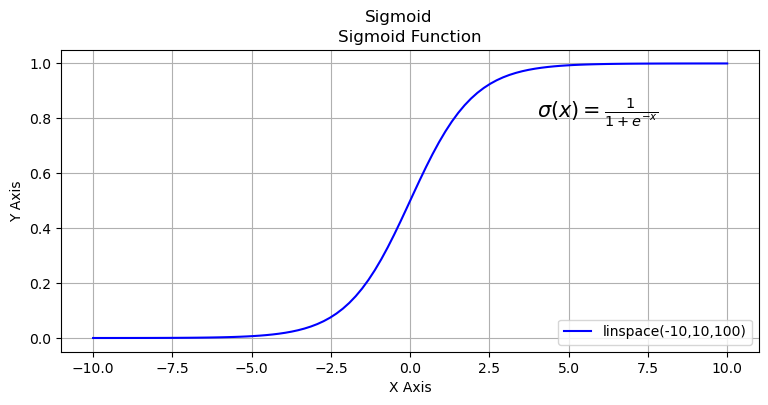

In [143]:
# https://gist.github.com/zhmz1326/5a6cad0eae9479205506
sigmoid = lambda x: 1 / (1 + np.exp(-x))
x = np.linspace(-10,10,100)
plt.figure(figsize=(9,4), dpi=100, linewidth=1)
plt.plot(x, sigmoid(x), 'b', label='linspace(-10,10,100)')
plt.grid()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Sigmoid Function')
plt.suptitle('Sigmoid')

plt.text(4,0.8,r'$\sigma(x)=\frac{1}{1+e^{-x}}$',fontsize=15)

plt.legend(loc='lower right')

It’s a beautifully smooth curve that guarantees y axis to be a 0 to 1 range. Let’s see how it performs on `df.data`.

In [89]:
def sigmoid(x):
    e = np.exp(1)
    y = 1/(1+e**(-x))
    return y

helpful_sigmoid = sigmoid(df.data)
helpful_sigmoid.describe()

count    8.898041e+06
mean     7.343560e-01
std      2.263828e-01
min      5.000000e-01
25%      5.000000e-01
50%      7.310586e-01
75%      9.820138e-01
max      1.000000e+00
Name: data, dtype: float64

In [90]:
sigmoid_cntr = Counter(map(lambda v: int(v*500), helpful_sigmoid.tolist()))
sorted(sigmoid_cntr.items(), key=lambda t: t[0])[:20]

[(250, 4141204),
 (365, 397492),
 (440, 1332984),
 (476, 335779),
 (491, 507694),
 (496, 204627),
 (498, 273489),
 (499, 1370431),
 (500, 334341)]

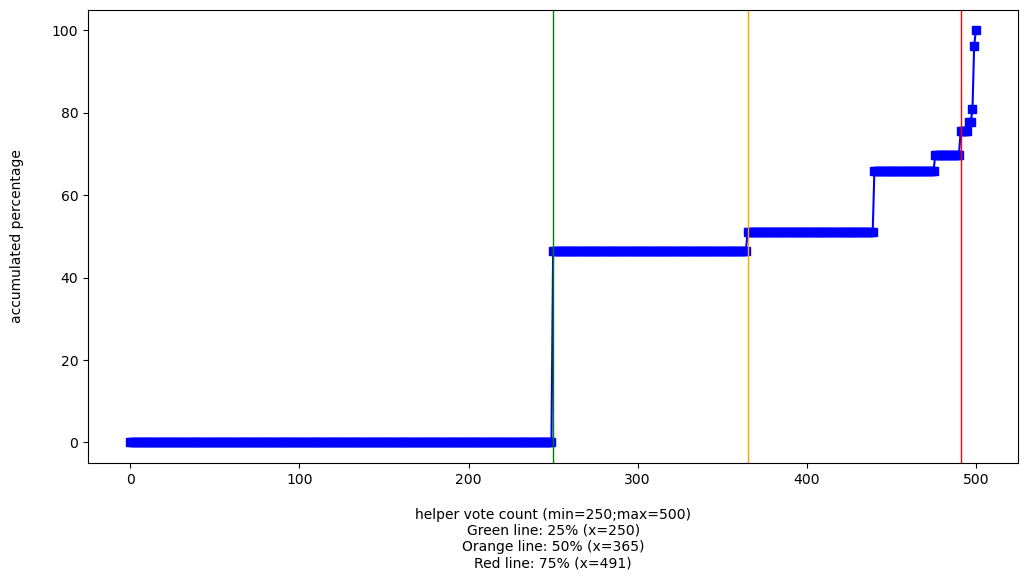

In [144]:
plot_accum_pert_dist(sigmoid_cntr, upper_bound=500)

A definite improvement. The new data is between 0 and 1 as expected, but the min is 0.5. This makes sense when looking at the graph as there are no negative values when tallying votes.

Another point of consideration is the spread. Here, the 75th percentile is within 0.2 of the 100th percentile, comparable to other quartiles. But in the original data, the 75th percentile more than 20,000 away from the 100th percentile, not remotely close to other quartiles. In this case, the data has been distorted.

The sigmoid function can be tweaked to improve results, but for now, let’s explore other options.

### <font color='darkgreen'>Log Function</font>
Next up, [**logarithms**](https://en.wikipedia.org/wiki/Logarithm). An excellent choice for making data less skewed. When using log with Python, the default base is usually `e`.

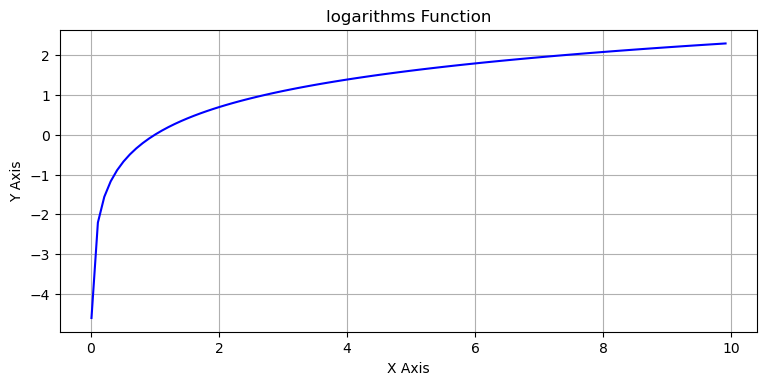

In [98]:
import math
x_axis = []
for i in np.arange(0.01, 10, 0.1):
    x_axis.append(i)

y_axis = list(map(lambda v: math.log(v), x_axis))
plt.figure(figsize=(9,4), dpi=100, linewidth=1)
plt.plot(x_axis, y_axis, 'b', label='y = log(x)')
plt.grid()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('logarithms Function')
# plt.suptitle(' logarithms')
# plt.legend(loc='lower right')
plt.show()

The domain for log is strictly greater than 0. That’s a vertical asymptote heading down the y-axis. <font color='darkred'><b>As x approaches 0, y approaches negative infinity. In other words, 0 is excluded from the domain.</b></font>

<b>Many of my data points are 0 because many reviews received no helpful votes. For a quick fix, I can add 1 to each data point. This works well since the log of 1 is 0</b>. Furthermore, the same spread is retained since all points are increased by 1.

In [100]:
helpful_log = np.log(df.data + 1)
helpful_log.describe()

count    8.898041e+06
mean     1.013985e+00
std      1.195112e+00
min      0.000000e+00
25%      0.000000e+00
50%      6.931472e-01
75%      1.609438e+00
max      1.076899e+01
Name: data, dtype: float64

In [132]:
bins = 100
logr_cntr = Counter(map(lambda v: int(v*bins), helpful_log.tolist()))
sorted(logr_cntr.items(), key=lambda t: t[0])[:20]

[(0, 4141204),
 (69, 397492),
 (109, 1332984),
 (138, 335779),
 (160, 507694),
 (179, 204627),
 (194, 273489),
 (207, 144149),
 (219, 174965),
 (230, 96911),
 (239, 119852),
 (248, 72083),
 (256, 91365),
 (263, 56672),
 (270, 68633),
 (277, 44806),
 (283, 53801),
 (289, 37625),
 (294, 43757),
 (299, 31556)]

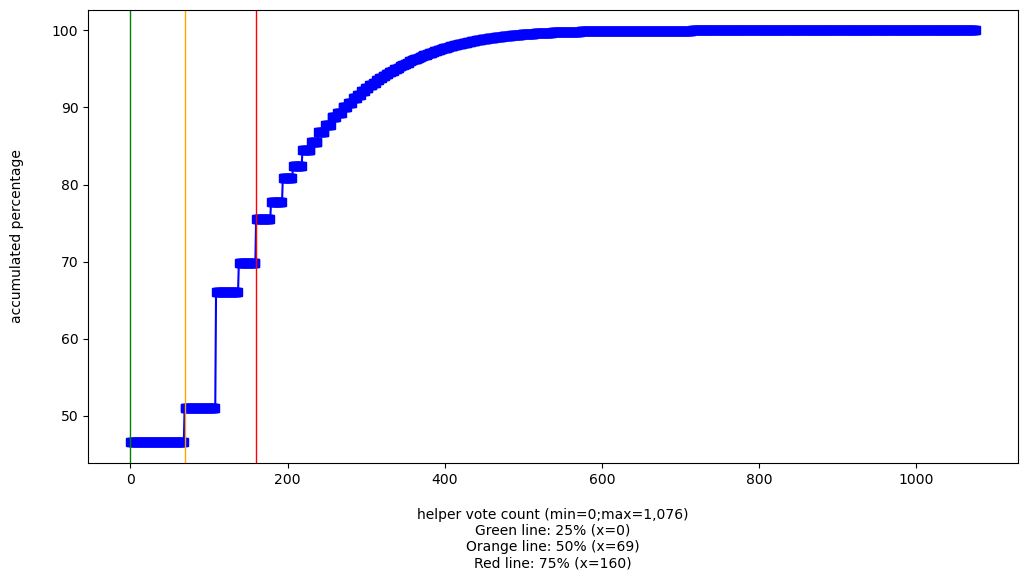

In [145]:
plot_accum_pert_dist(logr_cntr, upper_bound=int(bins*helpful_log.max()))

Excellent. The new range is from 0 to 10, and the quartiles are reflective of the original data.

### <font color='darkgreen'>Log Function + 1 Normalized</font>
Time to normalize.

In [105]:
helpful_log_normalized = normalize(helpful_log)
helpful_log_normalized.describe()

count    8.898041e+06
mean     9.415788e-02
std      1.109772e-01
min      0.000000e+00
25%      0.000000e+00
50%      6.436511e-02
75%      1.494511e-01
max      1.000000e+00
Name: data, dtype: float64

This looks very reasonable. The log function plus normalization is an excellent way to transform skewed data if the results can still be skewed. There is, however, one major drawback in this case.

Why transform data to values between 0 and 1 in the first place? It’s usually so percentages and probability can play a role. In my case, <font color='darkred'><b>I want the median at around 50%. After normalizing here, the median is at 0.06</b></font>.

### <font color='darkgreen'>Cube Root</font>
When numbers are too large, one can try fractional exponents as a means of transformation. Consider the [**cube root**](https://en.wikipedia.org/wiki/Cube_root).

In [106]:
helpful_cube_root = df.data ** (1/3)
helpful_cube_root.describe()

count    8.898041e+06
mean     1.005244e+00
std      1.148491e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.587401e+00
max      3.622163e+01
Name: data, dtype: float64

In [134]:
bins = 100
cube_cntr = Counter(map(lambda v: int(v*bins), helpful_cube_root.tolist()))
sorted(cube_cntr.items(), key=lambda t: t[0])[:20]

[(0, 4141204),
 (100, 397492),
 (125, 1332984),
 (144, 335779),
 (158, 507694),
 (170, 204627),
 (181, 273489),
 (191, 144149),
 (200, 174965),
 (208, 96911),
 (215, 119852),
 (222, 72083),
 (228, 91365),
 (235, 56672),
 (241, 68633),
 (246, 44806),
 (251, 53801),
 (257, 37625),
 (262, 43757),
 (266, 31556)]

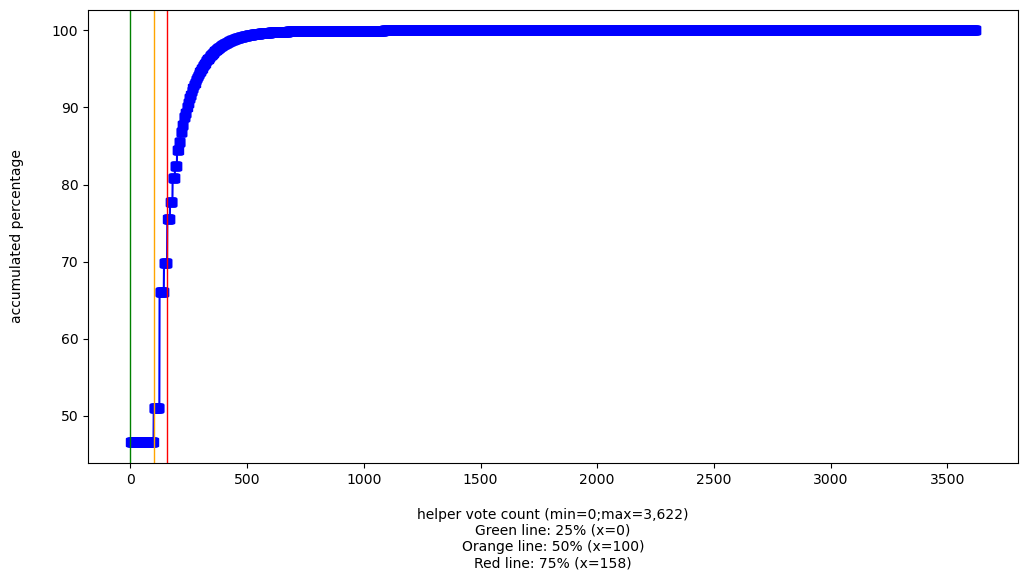

In [146]:
plot_accum_pert_dist(cube_cntr, upper_bound=int(helpful_cube_root.max()*bins))

This is very similar to log, but the range here is larger, from 0 to 36.

### <font color='darkgreen'>Cube Root Normalized</font>
Let's normalized the cube root result to have range from o to 1:

In [112]:
helpful_cube_root_normalized = normalize(helpful_cube_root)
helpful_cube_root_normalized.describe()

count    8.898041e+06
mean     2.775260e-02
std      3.170732e-02
min      0.000000e+00
25%      0.000000e+00
50%      2.760782e-02
75%      4.382468e-02
max      1.000000e+00
Name: data, dtype: float64

In [138]:
bins = 100
normalized_cube_cntr = Counter(map(lambda v: int(v*bins), helpful_cube_root_normalized.tolist()))
sorted(normalized_cube_cntr.items(), key=lambda t: t[0])[:20]

[(0, 4141204),
 (2, 397492),
 (3, 1668763),
 (4, 712321),
 (5, 809366),
 (6, 387360),
 (7, 256905),
 (8, 167141),
 (9, 115654),
 (10, 76717),
 (11, 51254),
 (12, 34101),
 (13, 23806),
 (14, 16264),
 (15, 11025),
 (16, 7954),
 (17, 5589),
 (18, 3870),
 (19, 2841),
 (20, 2072)]

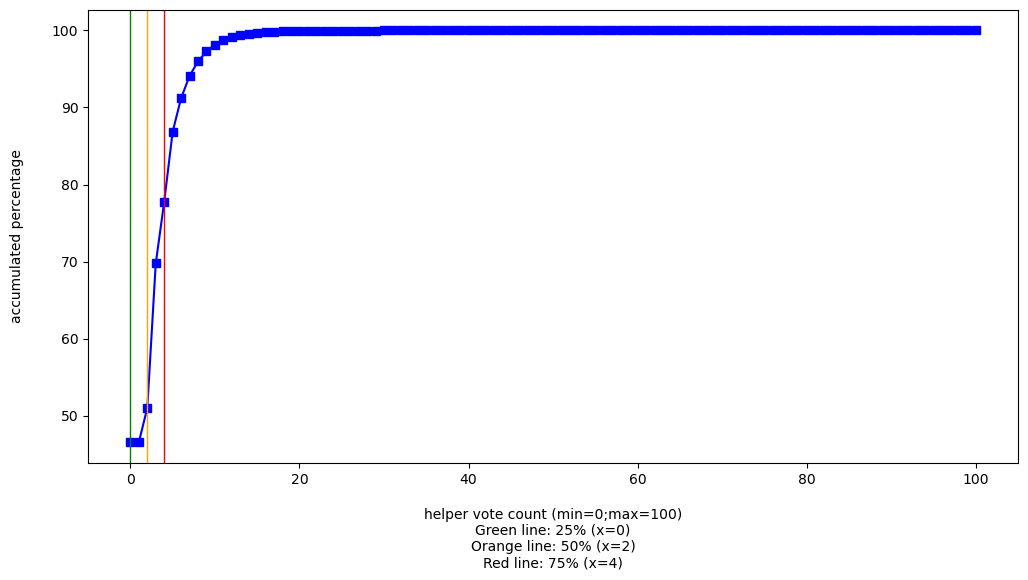

In [147]:
plot_accum_pert_dist(normalized_cube_cntr, upper_bound=bins)

As expected, <font color='darkred'><b>the new data is more problematic after normalizing</b></font>. Now the median is at 0.027, a far cry from 50%.

### <font color='darkgreen'>Log Max Root</font>

In [148]:
log_max = np.log(df.data.max())
helpful_log_max_root = df.data**(1/log_max)
helpful_log_max_root.describe()

count    8.898041e+06
mean     6.263290e-01
std      5.924842e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.137384e+00
max      2.718282e+00
Name: data, dtype: float64

In [149]:
bins = 100
log_max_cntr = Counter(map(lambda v: int(v*bins), helpful_log_max_root.tolist()))
sorted(log_max_cntr.items(), key=lambda t: t[0])[:20]

[(0, 4141204),
 (100, 397492),
 (106, 1332984),
 (110, 335779),
 (113, 507694),
 (116, 204627),
 (118, 273489),
 (119, 144149),
 (121, 174965),
 (122, 96911),
 (123, 119852),
 (124, 72083),
 (125, 91365),
 (126, 56672),
 (127, 68633),
 (128, 44806),
 (129, 53801),
 (130, 81382),
 (131, 31556),
 (132, 62828)]

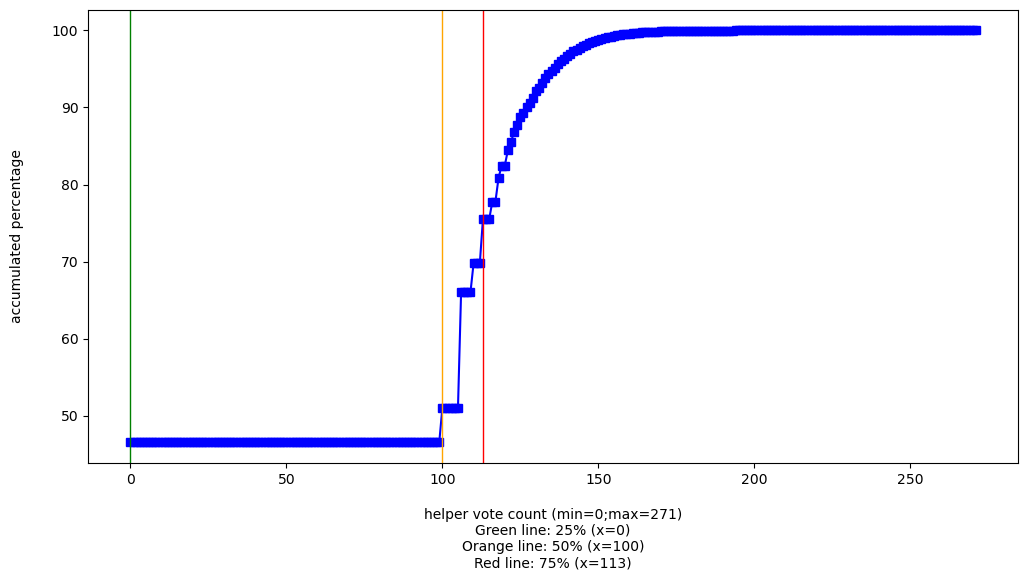

In [152]:
plot_accum_pert_dist(log_max_cntr, upper_bound=int(bins*helpful_log_max_root.max()))

A range from 0 to 2.7 is very appealing.

### <font color='darkgreen'>Log Max Root Normalized</font>

In [153]:
helpful_log_max_root_normalized = normalize(helpful_log_max_root)
helpful_log_max_root_normalized.describe()

count    8.898041e+06
mean     2.304136e-01
std      2.179628e-01
min      0.000000e+00
25%      0.000000e+00
50%      3.678794e-01
75%      4.184200e-01
max      1.000000e+00
Name: data, dtype: float64

In [154]:
bins = 100
log_max_normalized_cntr = Counter(map(lambda v: int(v*bins), helpful_log_max_root_normalized.tolist()))
sorted(log_max_normalized_cntr.items(), key=lambda t: t[0])[:20]

[(0, 4141204),
 (36, 397492),
 (39, 1332984),
 (40, 335779),
 (41, 507694),
 (42, 204627),
 (43, 273489),
 (44, 319114),
 (45, 288846),
 (46, 148037),
 (47, 204865),
 (48, 138141),
 (49, 141361),
 (50, 93527),
 (51, 84058),
 (52, 68622),
 (53, 49607),
 (54, 41492),
 (55, 30910),
 (56, 24033)]

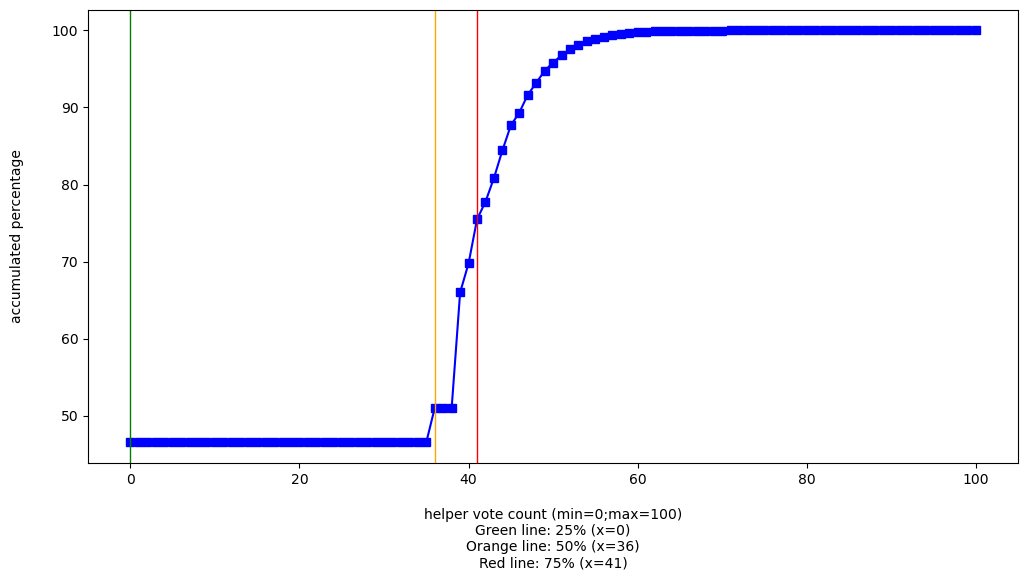

In [157]:
plot_accum_pert_dist(log_max_normalized_cntr, upper_bound=bins)

This looks good, but the <font color='darkred'><b>data’s very clustered in the 25–75% range, a cluster that likely extends much further</b></font>. So although the overall spread is more desirable, it’s not quite sufficient here.


### <font color='darkgreen'>Hyperbolic Tangent</font>
It’s time for our last standard function, the [**hyperbolic tangent**](https://en.wikipedia.org/wiki/Hyperbolic_functions). Let’s start with a graph.

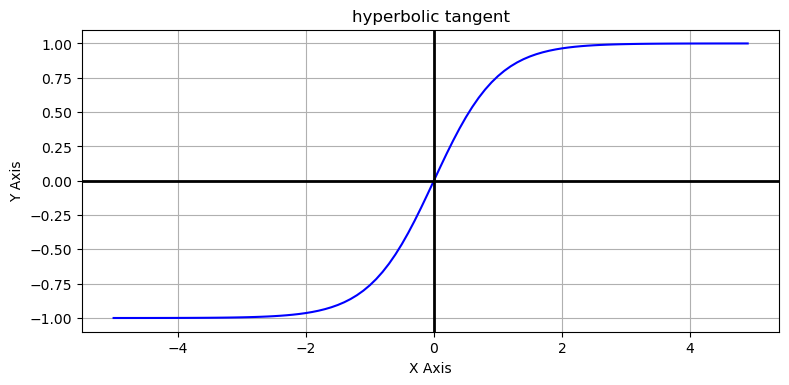

In [160]:
x_axis = []
for i in np.arange(-5, 5, 0.1):
    x_axis.append(i)
    
y_axis = list(map(lambda v: math.tanh(v), x_axis))
plt.figure(figsize=(9,4), dpi=100, linewidth=1)
plt.plot(x_axis, y_axis, 'b', label='y = log(x)')
plt.grid()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('hyperbolic tangent')
plt.axvline(x=0, linewidth=2, color='black')
plt.axhline(y=0, linewidth=2, color='black')
plt.show()

This looks very similar to the sigmoid. One primary difference is the range. <b>The hyperbolic tangent has a range from -1 to 1, whereas the sigmoid has a range from 0 to 1</b>. In my data, since `df.data` are all non-negative, my output will be from 0 to 1.

In [162]:
helpful_hyperbolic_tangent = np.tanh(df.data)
helpful_hyperbolic_tangent.describe()

count    8.898041e+06
mean     5.183274e-01
std      4.859338e-01
min      0.000000e+00
25%      0.000000e+00
50%      7.615942e-01
75%      9.993293e-01
max      1.000000e+00
Name: data, dtype: float64

In [163]:
bins = 100
helpful_hyperbolic_tangent_cntr = Counter(map(lambda v: int(v*bins), helpful_hyperbolic_tangent.tolist()))
sorted(helpful_hyperbolic_tangent_cntr.items(), key=lambda t: t[0])[:20]

[(0, 4141204), (76, 397492), (96, 1332984), (99, 2357764), (100, 668597)]

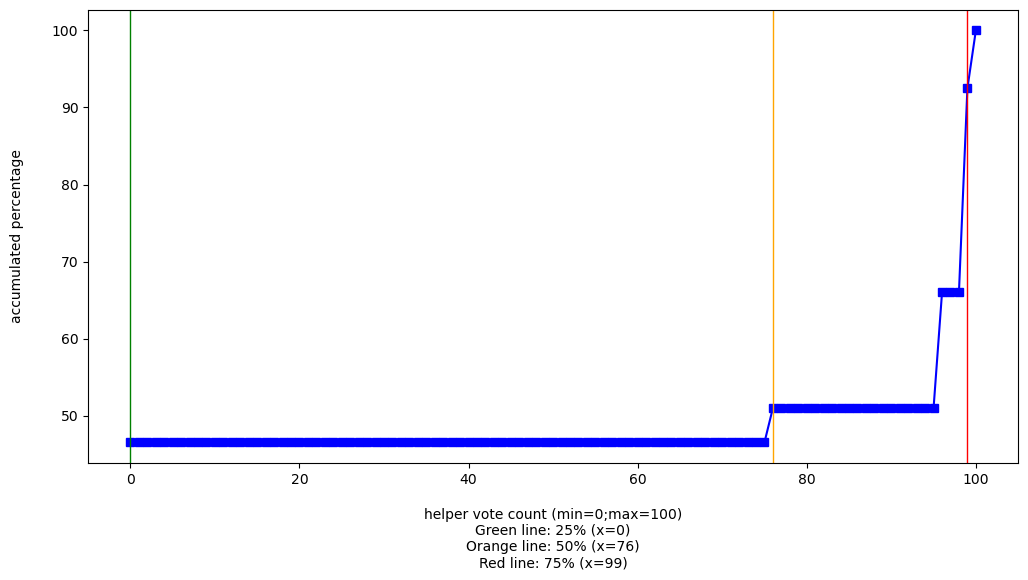

In [164]:
plot_accum_pert_dist(helpful_hyperbolic_tangent_cntr, upper_bound=bins)

There’s no need to normalize, but there’s one glaring issue. The hyperbolic tangent distorts the data more than the sigmoid. <font color='darkred'><b>There’s a difference of 0.001 between the 75th and 100th percentiles, much closer than any other quartile</b></font>. In the original data, that difference is 23,307, 1,000 times greater than the difference between other quartiles.

### <font color='darkgreen'>Percentile Linearization</font>
Percentiles provide yet another option. Each data point can be ranked according to its percentile, and <b>pandas provides a nice built-in method, [.rank](https://pandas.pydata.org/pandas-docs/version/0.24.2/reference/api/pandas.DataFrame.rank.html), for dealing with this.</b> ([more example about rank function](https://www.geeksforgeeks.org/python-pandas-dataframe-rank/))

The general idea is that each point receives the value of it’s percentile. In my case, since there are many data points with a low number of helpful votes, there are different ways for choosing these percentiles. I like the “min” method, where all data points receive the percentile given to the first member of the group. The default method is “average,” where all data points with the same value take the mean percentile in that group.

In [165]:
size = len(df.data)-1
helpful_percentile_linearization = df.data.rank(method="min").apply(lambda x: (x-1)/size)
helpful_percentile_linearization.describe()

count    8.898041e+06
mean     3.756791e-01
std      3.733484e-01
min      0.000000e+00
25%      0.000000e+00
50%      4.654063e-01
75%      6.976209e-01
max      1.000000e+00
Name: data, dtype: float64

In [166]:
bins = 100
helpful_percentile_linearization_cntr = Counter(map(lambda v: int(v*bins), helpful_percentile_linearization.tolist()))
sorted(helpful_percentile_linearization_cntr.items(), key=lambda t: t[0])[:20]

[(0, 4141204),
 (46, 397492),
 (51, 1332984),
 (65, 335779),
 (69, 507694),
 (75, 204627),
 (77, 273489),
 (80, 144149),
 (82, 174965),
 (84, 96911),
 (85, 119852),
 (86, 72083),
 (87, 91365),
 (88, 56672),
 (89, 68633),
 (90, 98607),
 (91, 81382),
 (92, 94384),
 (93, 81139),
 (94, 79984)]

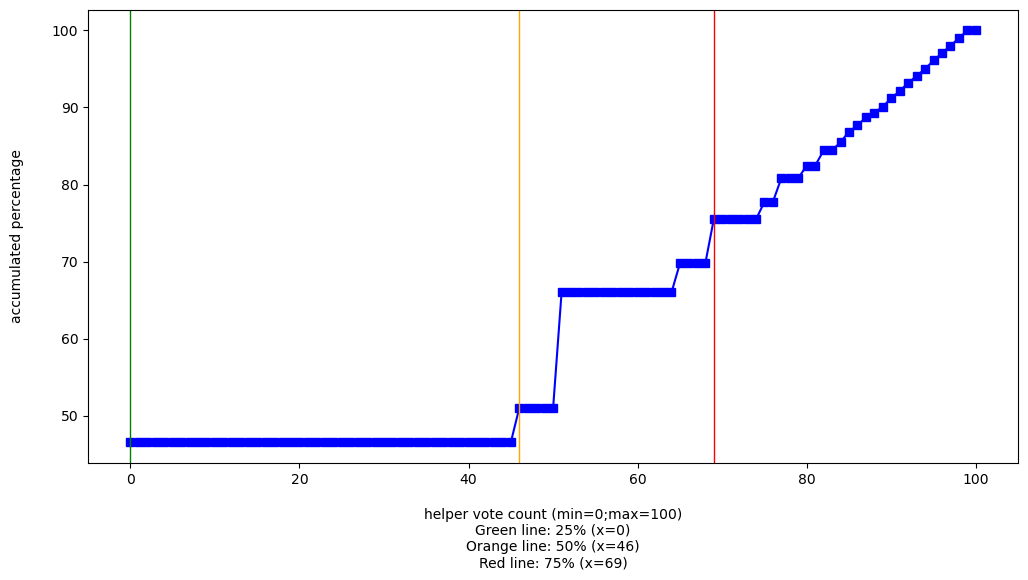

In [167]:
plot_accum_pert_dist(helpful_percentile_linearization_cntr, upper_bound=bins)

Intriguing. Percentile linearization is basically the same as a ranking system. If the difference between the 1st data point and the 2nd should be the same as all data points that are one unit part, percentile linearization is the way to go.

<font color='darkred'><b>On the downside, Percentile Linearization erases critical signs of skewness.</b></font> This data appears slightly skewed because there are hundreds of thousands of reviews with 1 and 2 votes, not because there are few reviews with an insanely high number of votes.

Since I am dealing primarily with a ranking system, I combined percentile linearization with my own piecewise linearization function. Logs also played a role. 

Whatever your choice or style, <b>never limit yourself to the standard options. Mathematical functions are extremely rich, and their intersection with data science deserves more recognition and flexibility.</b>

I would love to hear about other functions that people use for transforming skewed data. I have heard about the boxcox function, though I have yet to explore it in detail.

## <font color='darkblue'>Supplement</font>
* [DataCamp - Histograms in Matplotlib](https://www.datacamp.com/community/tutorials/histograms-matplotlib?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=278443377086&utm_targetid=aud-522010995285:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=1012825&gclid=Cj0KCQjw-af6BRC5ARIsAALPIlW5-irtvp7mKcrgIv0wJSF4qeDFpwMPiNMdIGPeg_VbH3jKC1hofigaApp_EALw_wcB)
* [Matplotlib-04 - 長條圖與直方圖](https://medium.com/%E8%B3%87%E6%96%99%E8%A6%96%E8%A6%BA%E5%8C%96/matplotlib-04-%E9%95%B7%E6%A2%9D%E5%9C%96%E8%88%87%E7%9B%B4%E6%96%B9%E5%9C%96-34ab1cfea0c4)